<a href="https://colab.research.google.com/github/AtilioFPedroni/Pc__Gillespie/blob/main/PC_Gelispe_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q networkx matplotlib numpy pandas seaborn

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

rng = np.random.default_rng()

In [ ]:
def processo_contato(g, lista_inicial_de_infectados, beta, mu, tf):
    
    # condicao inicial
    infectados = lista_inicial_de_infectados.copy()

    estados = {vertice: 0 for vertice in g.nodes()}
    
    for infectado in infectados:
        estados[infectado] = 1

    t = [0.0]
    n_infectados = [len(infectados)]

    n_infectados_atual = len(infectados)

    while t[-1] <= tf:

        if n_infectados_atual == 0:
            break

        taxa_total = beta * len(infectados) + mu * len(infectados)

        dt = -np.log(1.0 - rng.random()) / taxa_total

        # definir qual processo vai acontecer
        z = rng.random()
        if (z < mu*len(infectados) / taxa_total):
            # acontecer um processo de cura

            posicao_do_infectado = rng.integers(0, len(infectados)) # escolhe um infectado ao acaso, na posicao da lista
            infectado = infectados.pop(posicao_do_infectado) # retirar o infectado da lista

            estados[infectado] = 0

            n_infectados_atual -= 1

        else: # é equivalente a fazer elseif (z < beta*len(infectados) / taxa_total + mu*len(infectados) / taxa_total)
            # vai acontecer um processo de infecção

            # escolher um infectado ao acaso
            posicao_do_infectado = rng.integers(0, len(infectados)) # escolhe um infectado ao acaso, na posicao da lista

            infectado = infectados[posicao_do_infectado]

            # escolher um vizinho ao acaso
            vizinho = rng.choice(list(g.neighbors(infectado))) # escolher um vizinho ao acaso

            if estados[vizinho] == 0:
                infectados.append(vizinho) # adiciona ele à lista
                estados[vizinho] = 1

                n_infectados_atual += 1
            # caso contrário, nada é feito de diferente

        t.append(t[-1] + dt)
        n_infectados.append(n_infectados_atual)

    return t, n_infectados # sequencia dos tempos t e números de infectados em cada tempo, contínuo

In [6]:
#%%timeit -n 1 -r 1
def simulacao_1D(n, betas, mu=1.0, tf = 100, ni=1, n_amostras=1):
    results = {}

    G = nx.circulant_graph(n, [1])

    for beta in betas:
        results[beta] = []
        for id_da_amostra in range(n_amostras):
            lista_de_infectados_inicial = rng.choice(G.nodes(), size=ni).tolist()
            t, n_infectados = processo_contato(G, lista_de_infectados_inicial, beta, mu, tf)

            df = pd.DataFrame({'t': t, 'n_infectados': n_infectados})
            df['beta'] = beta
            df['id_da_amostra'] = id_da_amostra

            results[beta].append(df)
        results[beta] = pd.concat(results[beta])
    results = pd.concat(results.values())
    return results

######################################  Parâmetros ##############################

n = 100
betas = [0.1, 1, 1.5, 3.29, 5]
mu = 1.0
tf = 100
ni = 1

results = simulacao_1D(n, betas, mu, tf, ni, n_amostras=10)

results

,t,n_infectados,beta,id_da_amostra
0,0.000000,1,0.1,0
1,0.297196,0,0.1,0
0,0.000000,1,0.1,1
1,0.261051,0,0.1,1
0,0.000000,1,0.1,2
...,...,...,...,...
1,0.164489,0,5.0,8
0,0.000000,1,5.0,9
1,0.063738,2,5.0,9
2,0.145420,1,5.0,9


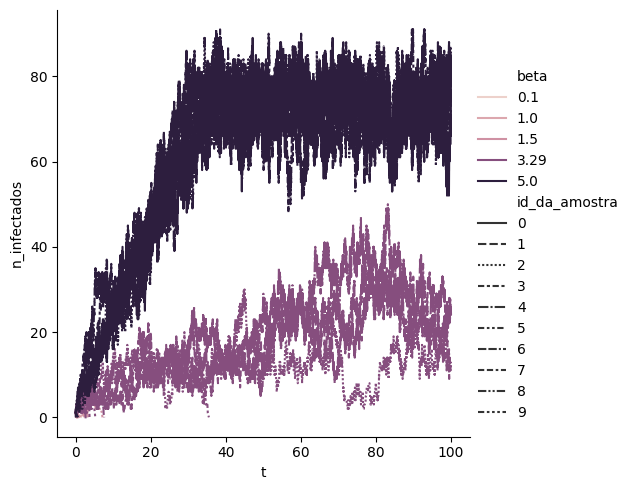

In [8]:
sns.relplot(data=results, x='t', y='n_infectados', hue='beta', style='id_da_amostra', kind='line')

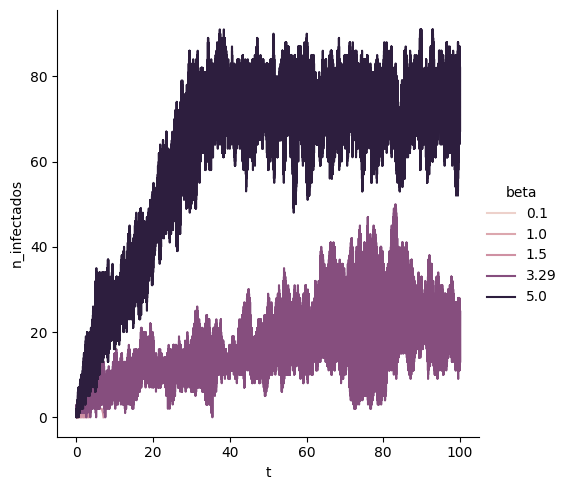

In [9]:
sns.relplot(data=results, x='t', y='n_infectados', hue='beta', kind='line')